In [34]:
import sys
sys.path.append("../")

from corona_nlp.dataset import AutoTokenizer, AutoModel
from corona_nlp.dataset import BERT_MODELS_UNCASED
from corona_nlp.utils import DataIO
import numpy as np

In [35]:
sentences = DataIO.load_data("biomed_sents")
embedding = np.array(DataIO.load_data("biomed_embedd"))
embedding.shape

(130759, 768)

In [31]:
bert_scibert_uncased = BERT_MODELS_UNCASED['scibert']
tokenizer = AutoTokenizer.from_pretrained(bert_scibert_uncased)

In [45]:
embedding.shape

(130759, 768)

## Finding K

> In the following code, we can see that the embeddings are relative in proportion to each other - since the sentences decrease respectably. Also, note that the sentences do come from the same source `biorxiv_medrxiv`.

- k : `9` (number of clusters based on the embeddings)

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

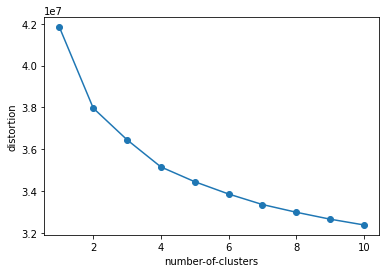

In [81]:
n_init = 10
maxrange = 11
distortions = []
for i in range(1, maxrange):
    km = KMeans(n_clusters=i, init='random',
                n_init=n_init, max_iter=300,
                tol=1e-04, random_state=0)
    km.fit(embedding)
    distortions.append(km.inertia_)

plt.plot(range(1, maxrange), distortions, marker='o')
plt.xlabel("number-of-clusters")
plt.ylabel("distortion")
plt.savefig("cluster_distortion.png")

In [97]:
import random
from sentence_transformers import SentenceTransformer
scibert_nli_model = "/home/ego/huggingface-models/scibert-nli/"
transformer = SentenceTransformer(scibert_nli_model)

# lets load and embedd five randomly chosen sentences
# and use them to query agains the clusters computations:
indices = random.sample(range(embedding.shape[0]), k=5)
queries = [sentences[i] for i in indices]
embedd_queries = np.asarray(transformer.encode(queries))
embedd_queries.shape

(5, 768)

In [50]:
dimension = embedding.shape[1]
nlist = 9 # number of clusters
quantiser = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantiser, dimension, nlist, faiss.METRIC_L2)
if not index.is_trained:
    index.train(embedding)
    index.add(embedding)

False

In [95]:
ncentroids = 9
niter = 20
dimension = embedding.shape[1]
kmeans = faiss.Kmeans(dimension, ncentroids, niter=niter, verbose=True)
kmeans.train(embedding)

577243.125

## Nearest Centroid per Embedded Query

> To compute the mapping from the embeddings to the cluster centroids after kmeans has finished training:

In [100]:
k = 1 # number of nearest neighbors per query
D, I = kmeans.index.search(embedd_queries, k)
I  # Index of most similar clusters

array([[6],
       [6],
       [1],
       [2],
       [5]])

In [107]:
for idx, dist, query in zip(I, D, queries):
    print(f'cluster({idx[0]}), distance: {dist[0]}\nQ : {query}\n')

cluster(6), distance: 342.02392578125
Q : Informed consent was obtained from all participating patients if they were 18 years or older, from both parents and patients if they were 12-18 years of age, and from parents only if they were younger than 12 years old.

cluster(6), distance: 326.0296936035156
Q : Since the daily incidence data is an integer, Poisson regression was used to fit the exponential growth rate.

cluster(1), distance: 263.2742004394531
Q : We further predict the out-of-the-set NCP confirmed cases and monitor that the next peak of new diagnoses will occur on February 16 th and 17 th .

cluster(2), distance: 245.18121337890625
Q : The figures and tables in this paper are generated by further Rmd scripts that operate on the standardized input data.

cluster(5), distance: 206.76113891601562
Q : bioRxiv preprint inhibition of the transcriptional complex that contains IRF9 (not shown).



> Computing the nearest points for all nine centroids (clusters) and obtaining `k` samples for each of the centroids.

In [108]:
index = faiss.IndexFlat(dimension)
index.add(embedding)
k = 15 
D2, I2 = index.search(kmeans.centroids, k)
I2

array([[ 68936,  87540,  41786,  81016,  57707,  18372,   9274,  83151,
        100985,  71430,  10261, 116465,  49384,  20718,  83573],
       [ 83819,  72933,  47823,  85195,  97327,  47144, 110321,  56448,
        101182,  89645,  10783,  36102,  12658,  55301,  73595],
       [ 78907,  84244,  92317, 123030,  36290,  68460,  48955, 128749,
          6954,  33749,  38222, 105797,  42366, 114682,  88442],
       [118772, 107762,   2599,  83309,  50618,   9727,  36345,  51062,
         98816,  13216, 121381,  83638,  44289,  24310,  99185],
       [ 13026, 113849, 115972,  26733,  26542,  57780,  18742,  36890,
         90439,   9605,  29852,   1752, 105879, 108021,   6809],
       [ 22657,  18569,  89385, 104751,  67653,  56021,  38478,  48590,
        129308,  71789, 112399, 115909,  87162,  75051, 128669],
       [ 23310,  77668,  22025, 127808,   6925,  99071,  23572,  34807,
         93986,  41568,  77222, 130282,   3161,   5657,  45222],
       [ 84468,  29006,  70283,  12285,  

In [113]:
n_centroids, n_nearest = I2.shape
print("number of centroids (clusters):", n_centroids)
print("number of nearest neighbors:", n_nearest)

number of centroids (clusters): 9
number of nearest neighbors: 15


In [140]:
for cluster in range(n_centroids):
    print(f"cluster({cluster + 1})\n")
    nearest_indices = I2[cluster]
    for i, sent_id in enumerate(nearest_indices):
        sentence = sentences[sent_id]
        print(f"< ({i}, sent_id={sent_id}) >\n * {sentence}")
    print()

cluster(1)

< (0, sent_id=68936) >
 * In brief, nucleic acids were prepared from culture material with high levels of 69 SARS-CoV-2 growth, and sequenced with use of poly(T) adaptors and an R9.4 flowcell on a 70 author/funder.
< (1, sent_id=87540) >
 * Hence, we conjectured that dead 3 Malayan pangolin may carry a new coronavirus close to 2019-nCoV. 4 To confirm our assumption, we downloaded raw RNA-seq data (SRA accession 5 number PRJNA573298) of those two lung samples from SRA and conducted consistent 6 quality control and contamination removing as described by Liu's study (7) .
< (2, sent_id=41786) >
 * It has proven [3] (https:// www.ncbi.nlm.nih.gov/genome/viruses/variation) includes specialized components that attempt to normalize annotation of previously submitted sequences for rotaviruses, dengue virus, West Nile virus, ebolaviruses, Zika virus, and MERS coronavirus.
< (3, sent_id=81016) >
 * Heatmap of differential expression values for interferome 341 genes, Table S1 : Genes 

In [144]:
papers_source = all_dataset_sources[1]
covid_source = PaperIndexing(papers_source)
covid_source

<PaperIndexing(comm_use_subset, papers=9000)>

In [145]:
covid_source.source_name

'comm_use_subset'

In [ ]:
DataIO.save_data()